# DSCI 100 Group Project

Group 006-21

Members: Kai-Yu She, Isik Karacelik, Kaasvi Bhatia, Vincent Kao

## Introduction

Understanding the factors that influence how long players engage with video games can provide valuable insights for game developers, marketers, and researchers. Session duration, or the amount of time a player spends in a single gaming session, is often used as an indicator of player engagement and satisfaction. By identifying which factors best predict session duration, developers can tailor game experiences, manage server capacity, and design targeted marketing strategies.

In this project, we aim to explore how player demographics and experience levels affect session duration. Specifically, we investigate whether factors such as age, gender, and gaming experience can serve as reliable predictors of average session length. This analysis could help game developers enhance player retention and improve overall user experience.

### Research Question

Our primary research question is:

> What combination of predictors (Age, Age + Gender, Age + Experience) best predicts average session duration?

By addressing this question, we hope to identify which demographic and experiential factors most significantly influence player engagement. This information can be used for targeted marketing, personalized game recommendations, and optimizing server management.

### Dataset Description

We used two datasets to conduct our analysis: `players.csv` and `sessions.csv`. The data was collected by a research group in the Computer Science department at UBC, which is studying player behaviour using a Minecraft server. The datasets provide detailed information about the players and their in-game activity.

1. **Players Dataset** (`players.csv`)
   - **Observations**: 196 players
   - **Variables**
     - `experience`: Categorical variable representing player experience level (Pro, Veteran, Amateur, or Regular)
     - `subscribe`: Boolean variable indicating whether the player subscribed to a game-related newsletter
     - `hashedEmail`: An anonymized identifier for each player
     - `played_hours`: Total number of hours the player has spent in the game
     - `name`: Player’s anonymized name (not relevant for analysis)
     - `gender`: Gender of the player (Male, Female, or Other)
     - `Age`: Age of the player (some missing values)
2. **Sessions Dataset** (`sessions.csv`)
   - **Observations**: 1,535 sessions
   - **Variables**:
     - `hashedEmail`: Anonymized identifier to link sessions with the players
     - `start_time`: Timestamp for when the session started
     - `end_time`: Timestamp for when the session ended (some missing values)
     - `original_start_time`: Unix timestamp for the start of the session
     - `original_end_time`: Unix timestamp for the end of the session

We calculated the **session duration** by subtracting the start time from the end time for each session. After merging the datasets using the `hashedEmail` variable, we were able to analyze the relationship between session duration and player characteristics.

Potential issues in the data included missing age values and incomplete session end times, which were handled using appropriate imputation and cleaning techniques.

This cleaned and integrated dataset served as the foundation for our analysis to answer the research question effectively.

## Methods & Results

In [1]:
library(dplyr)
library(ggplot2)
library(readr)
library(tidyr)
library(repr)
library(cowplot)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

players <- read_csv("https://raw.githubusercontent.com/LearningMachine0/dsci100-project-group-006-21/refs/heads/main/data/players.csv")
sessions <- read_csv("https://raw.githubusercontent.com/LearningMachine0/dsci100-project-group-006-21/refs/heads/main/data/sessions.csv")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ lubridate::stamp() masks cowplot::stamp()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick   

In [2]:
nsessions <- sessions |>
    mutate(start_time = dmy_hm(start_time), end_time = dmy_hm(end_time))|>
    mutate(session_duration = as.numeric(difftime(end_time, start_time, units = "min")))

player_sessions <- nsessions|>
    group_by(hashedEmail) |>
    summarise(total_playtime = sum(session_duration, na.rm = TRUE),
             session_count = n(),
             avg_session_duration = mean(session_duration, na.rm = TRUE))

mplayers <- players |>
    mutate(gender = as.factor(gender),
          experience = as.factor(experience))

merged_data <- inner_join(mplayers, player_sessions, by = "hashedEmail")
head(merged_data)

experience,subscribe,hashedEmail,played_hours,name,gender,Age,total_playtime,session_count,avg_session_duration
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<int>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2019,27,74.77778
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,255,3,85.00000
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,5,1,5.00000
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,50,1,50.00000
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,9,1,9.00000
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21,5,1,5.00000


### Data Loading and Cleaning<br>
We began by importing the two datasets: players.csv and sessions.csv. The players dataset contained player-level demographic and gameplay characteristics such as Age, Gender, Experience, and played hours. The sessions dataset recorded individual gameplay sessions, including start and end times, and was indexed by hashedEmail.

Since the unit of analysis for our models is the player and our target variable is the average session duration per player, we needed to aggregate the session-level data into player-level summaries. We did this by:<br>
1. Converting the start_time and end_time columns from string format to datetime objects. <br>
2. Calculating session duration (in minutes) for each row by subtracting start time from end time.<br>
3. Computing the average session duration per player by grouping the session dataset by hashedEmail and taking the mean of session durations for each player.<br>
4. Merging the resulting average duration back into the players dataset using inner_join function,ensuring every player retained their demographic info – evenif they had no sessions(in which case their average duration was set to zero).

To prepare the dataset for analysis, we encoded Gender and Experience as categorical variables using as.factor() so that they could be properly interpreted as fixed effects in modeling. 


### Exploratory data analysis

In [3]:
summary(merged_data$Age)
summary(merged_data$avg_session_duration)
table(merged_data$gender)
table(merged_data$experience)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   8.00   17.00   19.00   20.61   22.50   50.00       2 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5.00   10.00   18.50   32.51   43.00  150.34 


          Agender            Female              Male        Non-binary 
                1                24                83                 6 
            Other Prefer not to say      Two-Spirited 
                1                 6                 4 


 Amateur Beginner      Pro  Regular  Veteran 
      42       22       11       23       27 

*Numeric summaries*: summary() give us the mean, median, range, and skew of avg_session duration and Age, which helps justify modeling choices.<br> 
*Categorical summaries*: table() gice us counts of gender and expeirence categories - important to assess balance across groups.


#### Summary of the Dataset<br>
* Target Variable - Average Session Duration:<br>
    * Range from 5 to 150 minutes
    * Mean: 20.6 minutes; Median: 9.5 minutes
    * Highly right-skewed, with a few players with very long sessions
* Predictors:
    * **Age**: numeric, 8 to 50 years old; most players are between 17 and 22
    * **Gender**: Mostly Male (83 out 125 players); other categories present but underrepresented
    * **Experience**: 5 levels (Ameteur, Beginner, Pro, Regular, and Veteran); Amateur is the most common <br>
    
There were a small number of missing values in Age(2 players). The dataset is skewed toward younger, male players, and the majority fall under the Amateur experience category. Based on the skew in the avg_session_duration variable and the categorical nature of our predictors, we chose to use histograms and bar plots to better understand distribution shapes and group imbalances before modeling.

### Visualization

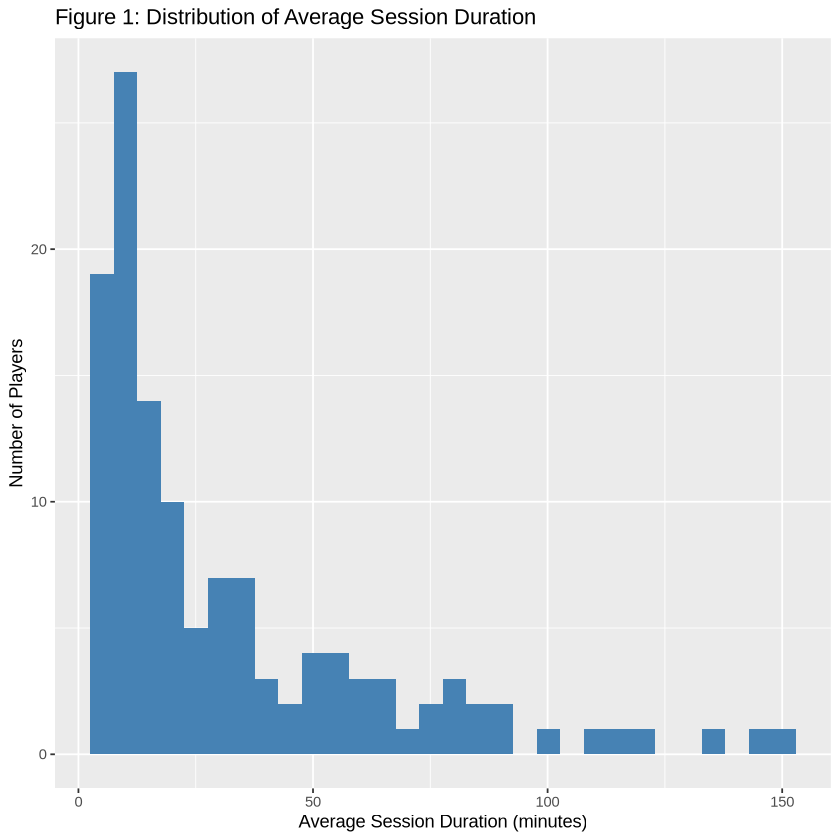

In [4]:
ggplot(merged_data, aes(x = avg_session_duration)) +
  geom_histogram(bins = 30, fill = "steelblue") +
  labs(
    title = "Figure 1: Distribution of Average Session Duration",
    x = "Average Session Duration (minutes)",
    y = "Number of Players"
  ) 

**Purpose:** To understand how the target variable avg_session_duration is distributed across the dataset.<br>
**Interpretation:**
* The distribution is highly right-skewed.
* Many players have low session duration, while a few players spend a long time in sessions.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


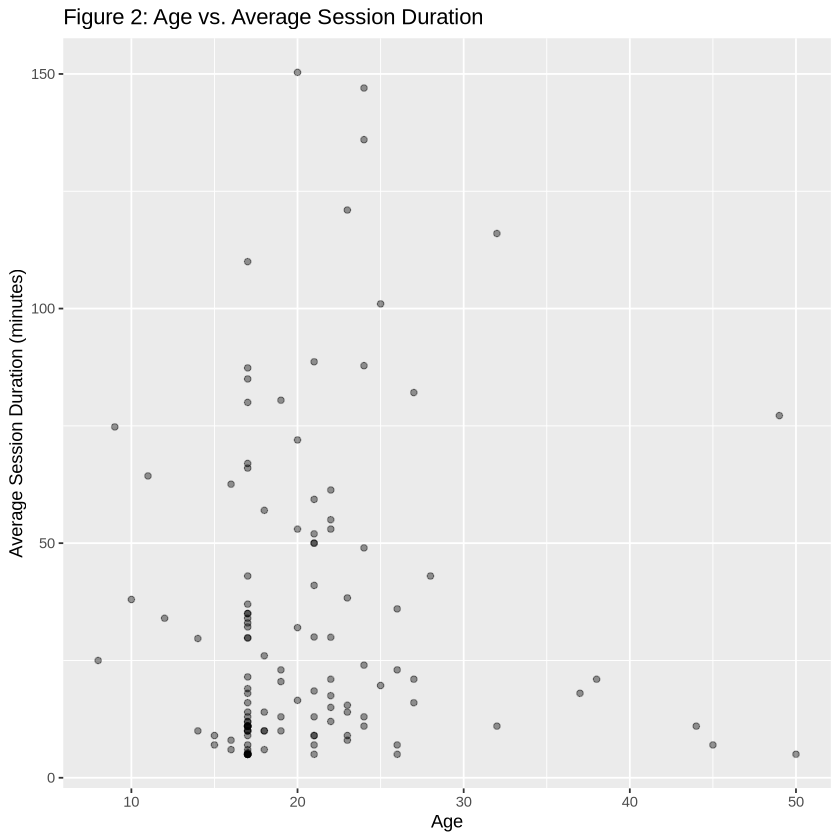

In [5]:
ggplot(merged_data, aes(x = Age, y = avg_session_duration)) +
  geom_point( alpha = 0.4) +
  labs(
    title = "Figure 2: Age vs. Average Session Duration",
    x = "Age",
    y = "Average Session Duration (minutes)"
  )

**Purpose:** To visualize any relationship between Age and the target variable.<br>
**Interpretation:**
* There is no clear linear relationship, but we can observe some clusters.
* Players around age 18 to 22 show a high variance in session duration.
* Younger players and older players appear less represented or have lower engagement.

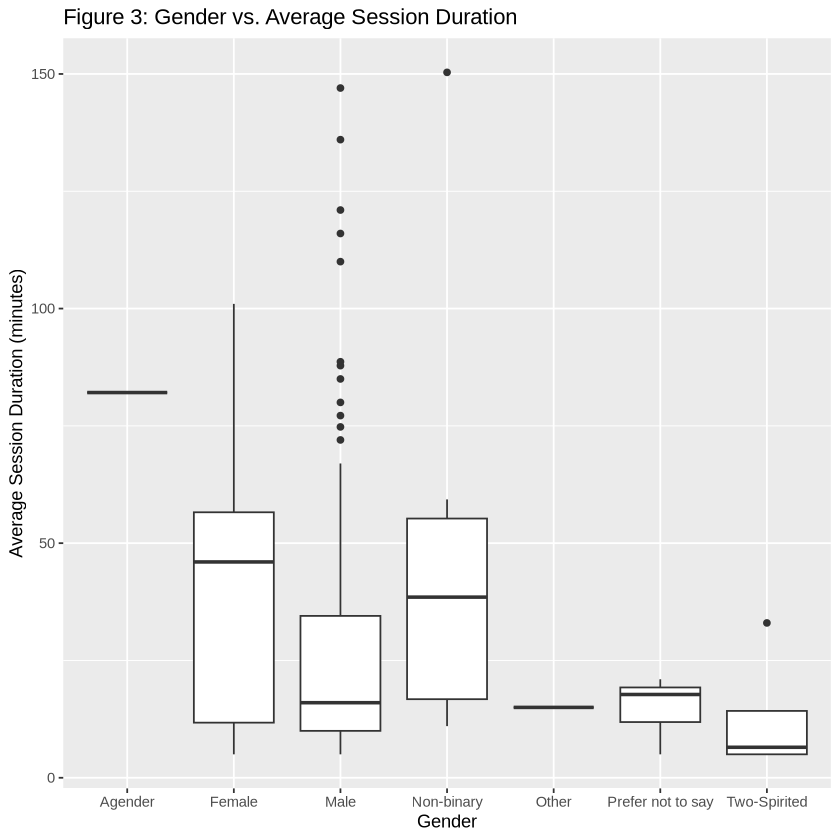

In [6]:
ggplot(merged_data, aes(x = gender, y = avg_session_duration)) +
  geom_boxplot() +
  labs(
    title = "Figure 3: Gender vs. Average Session Duration",
    x = "Gender",
    y = "Average Session Duration (minutes)"
  )

**Purpose:** To compare engagement across different gender groups. <br>
**Interpretation**:
* The median session duration appears similar across groups.
* Samller groups(e.g., non-binary, agender) have few data points - so insights for those categories may not generalize.

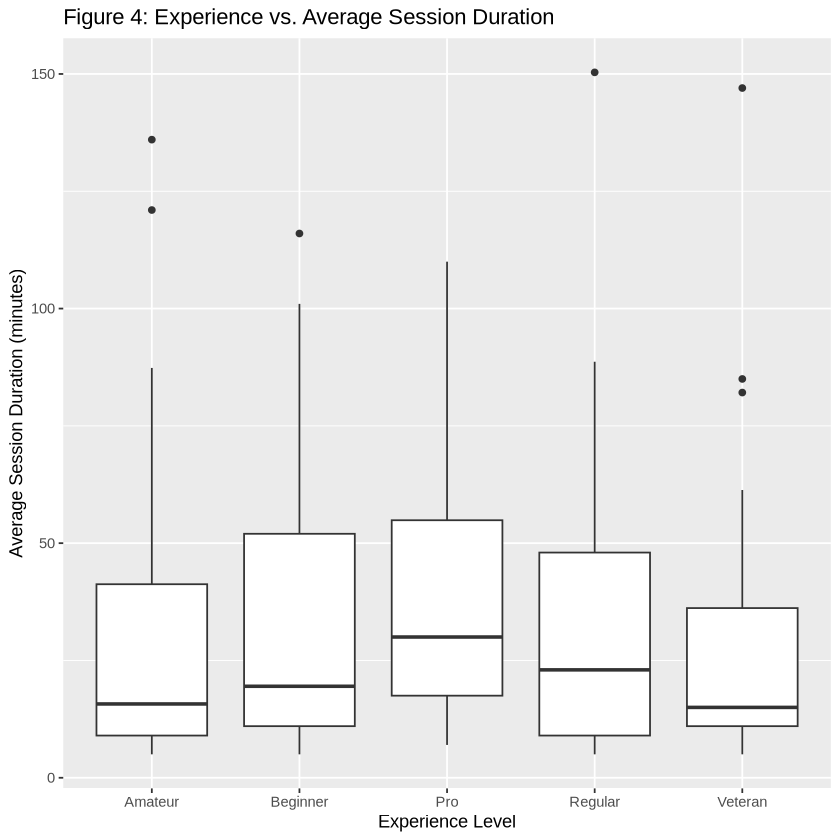

In [7]:
ggplot(merged_data, aes(x = experience, y = avg_session_duration)) +
  geom_boxplot() +
  labs(
    title = "Figure 4: Experience vs. Average Session Duration",
    x = "Experience Level",
    y = "Average Session Duration (minutes)"
  )

**Purpose:** To evaluate whether experience level correlates with time spent per session.<br>
**Interpretation:**
* Players with Veteran or Pro experience tend to have higher average session durations.
* Amateurs and Beginners have lower medians and fewer outliers.
* Supports the idea that more experienced players are more engaged, and that experience could be a strong predictor when combined with Age. 

### Model

To predict the average session durations, we will use a $k$-NN regression model. We chose this over linear regression modelling due to the nature of the dataset variables. For example, in Fig. 2 we see many points peak at ages 15 to 30, then generally decreasing everywhere else. This trend is not-linear, and thus will not be represented well using straight line regression. $k$-NN regression relies on the values of neighbouring pounts to assign the predicted value, and thus is more flexible in trend shape.

We will now create our models. As stated, three models will be created with different combinations of predictors (`Age`, `Age + gender`, `Age + experience`) and assessed to choose the best performing one. A 5 fold cross validation and neighbour range from 1 to 50 will be used.

The formulas for each model is listed below:
1. Model 1: `avg_session_duration ~ Age`
2. Model 2: `avg_session_duration ~ Age + gender`
3. Model 3: `avg_session_duration ~ Age + experience`

This section will be in three parts:
1. Splitting the dataset into training and testing sets
   - The total dataset will be split into 80% training and 20% testing
2. Creating and training the models
3. Evaluating the models against the testing set
   - The best model will be the one with the lowest RMSPE value
  
Note that for reproducibility, a static seed value will be used.

In [8]:
seed_value <- 2179

In [9]:
# creating the split
set.seed(seed_value)
model_dataset <- merged_data |> na.omit()
    
players_split <- initial_split(model_dataset, prop = 0.80, strata = avg_session_duration)
players_training <- training(players_split)
players_testing <- testing(players_split)

In [10]:
# creating the model recipes
set.seed(seed_value)

recipe1 <- recipe(avg_session_duration ~ Age, data = players_training) |>
    # step_impute_mean(all_predictors()) |>
    step_scale(Age) |>
    step_center(Age)

recipe2 <- recipe(avg_session_duration ~ Age + gender, data = players_training) |>
    # step_impute_mean(all_predictors()) |>
    step_scale(Age) |>
    step_center(Age)

recipe3 <- recipe(avg_session_duration ~ Age + experience, data = players_training) |>
    # step_impute_mean(all_predictors()) |>    
    step_scale(Age) |>
    step_center(Age)

In [11]:
# creating the workflows and gathering results
# the best results will be used to create new models for actual testing
# best results: neighbour count with the lowest RMSE value for each predictor combination
# cross-validation and neighbour values list objects will be reused
set.seed(seed_value)

# all first fits use the same model specification
players_first_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

players_vfold <- vfold_cv(players_training, v = 5, strata = avg_session_duration)
gridvals <- tibble(neighbors = seq(1, 40, 1))

In [12]:
# model 1 first pass results
set.seed(seed_value)

results1_metrics <- workflow() |>
    add_recipe(recipe1) |>
    add_model(players_first_spec) |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics()

results1 <-  results1_metrics |>
    filter(.metric == "rmse") |>
    slice_min(mean, n = 1)

results1

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
27,rmse,standard,33.04766,5,2.016803,Preprocessor1_Model27


In [13]:
# model 2 first pass results
set.seed(seed_value)

results2_metrics <- workflow() |>
    add_recipe(recipe2) |>
    add_model(players_first_spec) |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics()

results2 <- results2_metrics |>
    filter(.metric == "rmse") |>
    slice_min(mean, n = 1)

results2

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
17,rmse,standard,33.06363,5,1.869118,Preprocessor1_Model17


In [14]:
# model 3 first pass results
set.seed(seed_value)

results3_metrics <- workflow() |>
    add_recipe(recipe3) |>
    add_model(players_first_spec) |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics()

results3 <- results3_metrics |>
    filter(.metric == "rmse") |>
    slice_min(mean, n = 1)

results3

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
34,rmse,standard,33.23974,5,2.206247,Preprocessor1_Model34


In [15]:
# creating the new models with best neighbour counts
set.seed(seed_value)

model1_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = results1$neighbors) |>
    set_engine("kknn") |>
    set_mode("regression")

model2_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = results2$neighbors) |>
    set_engine("kknn") |>
    set_mode("regression")

model3_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = results3$neighbors) |>
    set_engine("kknn") |>
    set_mode("regression")

In [16]:
# creating the best fits for the three models
model1_best_fit <- workflow() |>
    add_recipe(recipe1) |>
    add_model(model1_best_spec) |>
    fit(data = players_training)

model2_best_fit <- workflow() |>
    add_recipe(recipe2) |>
    add_model(model3_best_spec) |>
    fit(data = players_training)

model3_best_fit <- workflow() |>
    add_recipe(recipe3) |>
    add_model(model3_best_spec) |>
    fit(data = players_training)

In [17]:
# performance evaluations
# as stated, the performance is guaged using the testing set
set.seed(seed_value)

model1_summary <- model1_best_fit |>
    predict(players_testing) |>
    bind_cols(players_testing) |>
    metrics(truth = avg_session_duration, estimate = .pred)

model2_summary <- model2_best_fit |>
    predict(players_testing) |>
    bind_cols(players_testing) |>
    metrics(truth = avg_session_duration, estimate = .pred)

model3_summary <- model3_best_fit |>
    predict(players_testing) |>
    bind_cols(players_testing) |>
    metrics(truth = avg_session_duration, estimate = .pred)

model1_summary
model2_summary
model3_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,29.07399644
rsq,standard,0.05370004
mae,standard,23.01600898


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,27.969475
rsq,standard,0.237052
mae,standard,22.272290


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,29.412964016
rsq,standard,0.008082483
mae,standard,24.887038861


The above three tables are the testing dataset prediction results for the three models, ordered respectively. The value we are focusing on is the RMSPE (root mean squared prediction error), calculated as $\text{RMSPE} = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(y_i-\hat{y_i}\right)^2}$, where $y_i$ is the actual value and $\hat{y_i}$ is the corresponding predictor value. This metric will help us guage the accuracy and precision of our models.

The RMSPE results are as follows:

1. Model 1 (predictor: Age): 29.07399644
   - $k=27$
2. Model 2 (predictors: Age + gender): 27.969475
   - $k=17$
3. Model 3 (predictors: Age + experience): 29.412964016
   - $k=34$

We see that all models had predictions around half an hour apart from the true values. Model 2 showed the best performance (lowest RMSPE), and thus is the best model by our definition.

Interestingly, the RMSE values (training data) are equal between all models within 1 minute.

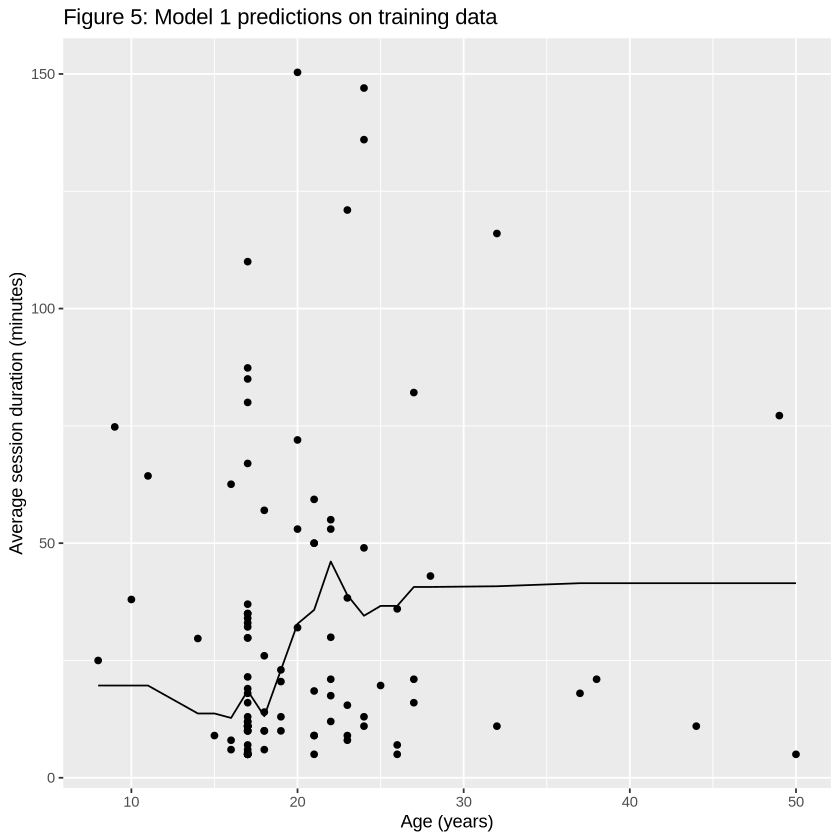

In [18]:
# Graphs for training data comparison
# Model 1
model1_training_comparison <- model1_best_fit |>
    predict(players_training) |>
    bind_cols(players_training) |>
    ggplot() +
    geom_point(aes(x = Age, y = avg_session_duration)) +
    geom_line(aes(x = Age, y = .pred)) +
    labs(x = "Age (years)",
         y = "Average session duration (minutes)") +
    ggtitle("Figure 5: Model 1 predictions on training data")

model1_training_comparison

**Purpose**: to evaluate the first model's performance against the training data

**Observations**: We see a straight prediction line from ~7 to 11 years, then a more varied response until ~27 years, then a rather straight line until the end. This could be explained by the higher density of player data with ages in betwwen the varied line section. The line only has a range of ~12 to 45 minutes. This may be due to the large $k$ value in relation to the total number of observations in the training set. A high $k$ value means that more observations are considered in the prediction, thus it will be insensitive to a few outlier points.

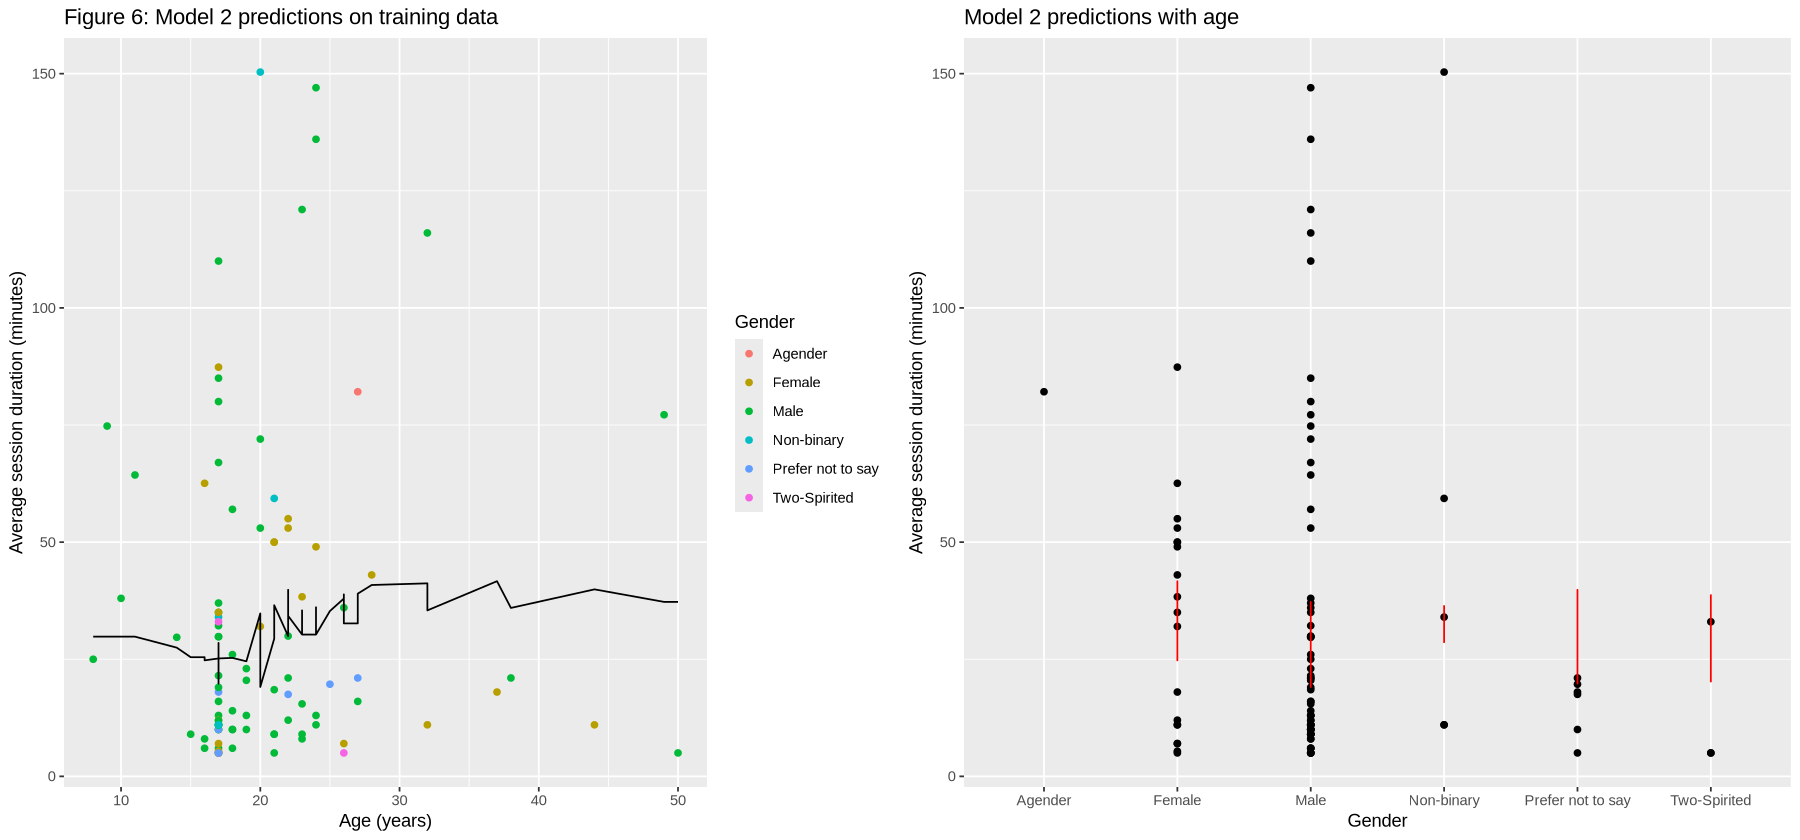

In [19]:
# Model 2
options(repr.plot.width = 15)

model2_training_results <- model2_best_fit |>
    predict(players_training) |>
    bind_cols(players_training)

model2_training_comparison_age <- model2_training_results |>
    ggplot() +
    geom_point(aes(x = Age, y = avg_session_duration, color = gender)) +
    geom_line(aes(x = Age, y = .pred)) +
    labs(x = "Age (years)",
         y = "Average session duration (minutes)",
         color = "Gender") +
    ggtitle("Figure 6: Model 2 predictions on training data")

model2_training_comparison_gender <- model2_training_results |>
    ggplot() +
    geom_point(aes(x = gender, y = avg_session_duration)) +
    geom_line(aes(x = gender, y = .pred), color = "red") +
    labs(title = "Model 2 predictions with age",
         x = "Gender",
         y = "Average session duration (minutes)")

model2_training_comparison <- plot_grid(model2_training_comparison_age, model2_training_comparison_gender, ncol = 2)

model2_training_comparison

**Purpose**: to evaluate the second model's performance against the training data

**Observations**: It is difficult to view the relationship between and estimate and two predictor variables, but we can see a part of the situation with these two graphs. On the left, we see that the predictions are much more variable, with several spikes in the region with dense points. This model also has the lowest $k$ value, which could explain the increased sensitivity compared to the first model. On the right, we see how the predictions match with the distributions of gender. This model seems to focus its range on the dense region of the male category, and somewhere in the middle for female. However, we see that the ranges are as precise for other genders. For example, the model generally overpredicted average session durations for the category "Prefer not to say."

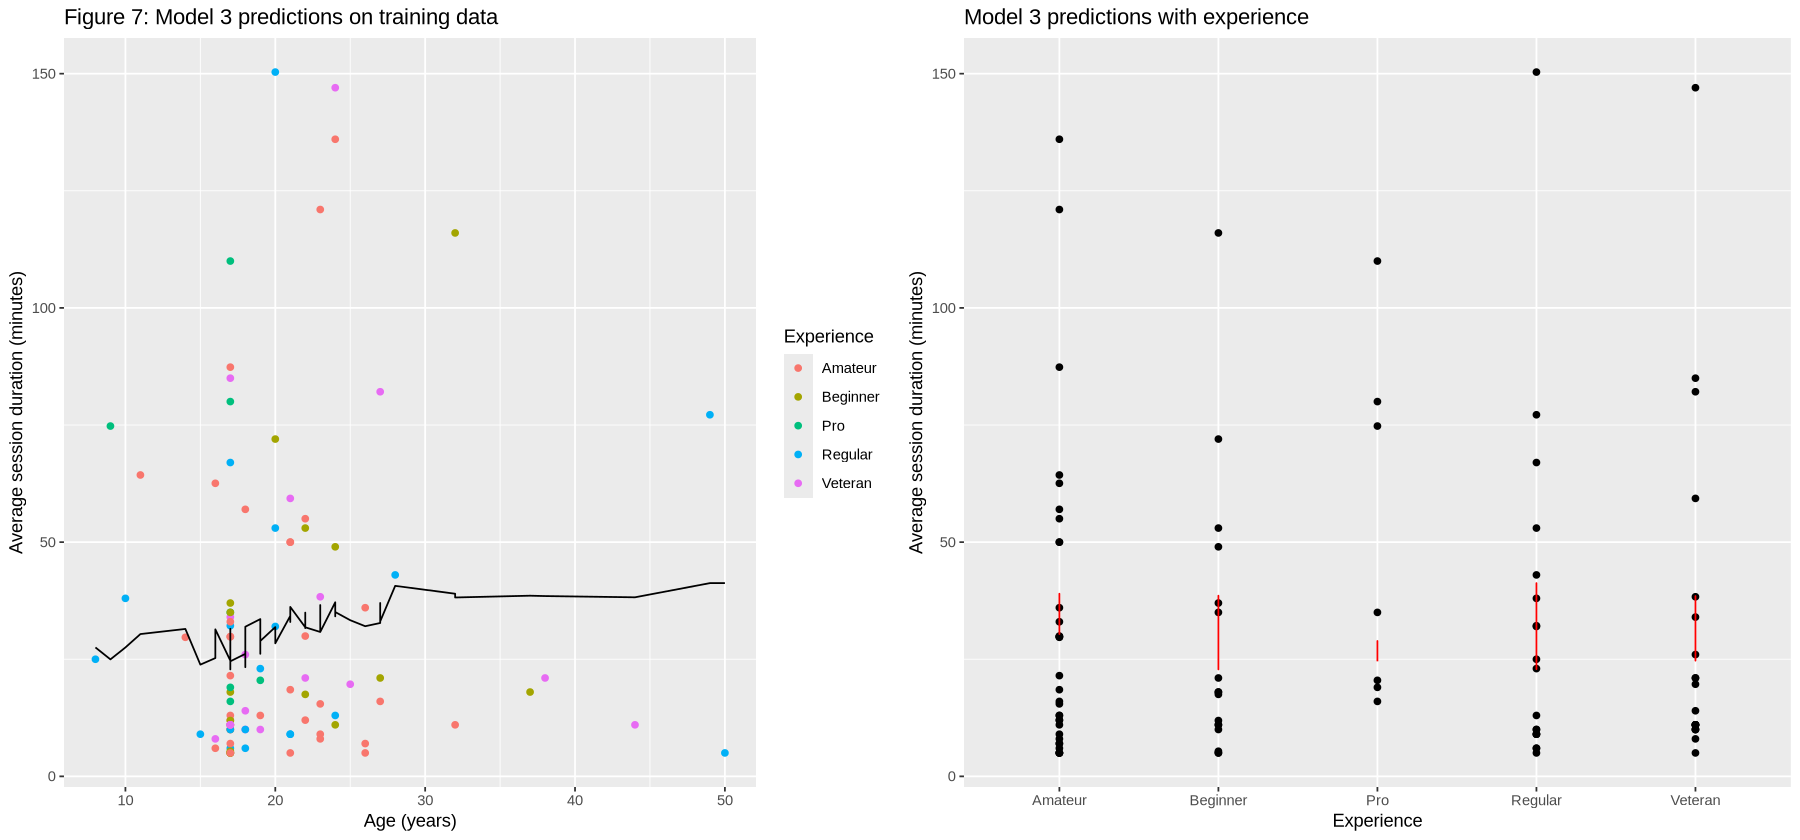

In [20]:
# Model 3
options(repr.plot.width = 15)

model3_training_results <- model3_best_fit |>
    predict(players_training) |>
    bind_cols(players_training)

model3_training_comparison_age <- model3_training_results |>
    ggplot() +
    geom_point(aes(x = Age, y = avg_session_duration, color = experience)) +
    geom_line(aes(x = Age, y = .pred)) +
    labs(x = "Age (years)",
         y = "Average session duration (minutes)",
         color = "Experience") +
    ggtitle("Figure 7: Model 3 predictions on training data")

model3_training_comparison_gender <- model3_training_results |>
    ggplot() +
    geom_point(aes(x = experience, y = avg_session_duration)) +
    geom_line(aes(x = experience, y = .pred), color = "red") +
    labs(title = "Model 3 predictions with experience",
         x = "Experience",
         y = "Average session duration (minutes)")

model3_training_comparison <- plot_grid(model3_training_comparison_age, model3_training_comparison_gender, ncol = 2)

model3_training_comparison

**Purpose**: to evaluate the third model's performance against the training data

**Observations**: We see a similar "spiky" pattern in the left graph compared with model 2's behaviour. Interestingly, this model had the highest $k$ value. This could imply that the experience factor significantly contributed to the prediction's variability. Still, we see that the predictions are quite far from many respective training observations. Looking at the model prediction and the experience factor (right plot), we see that the range of predictions is confined within the range of training values, and is quite narrow. These patterns could explain how this model did not perform well compared to the other two.

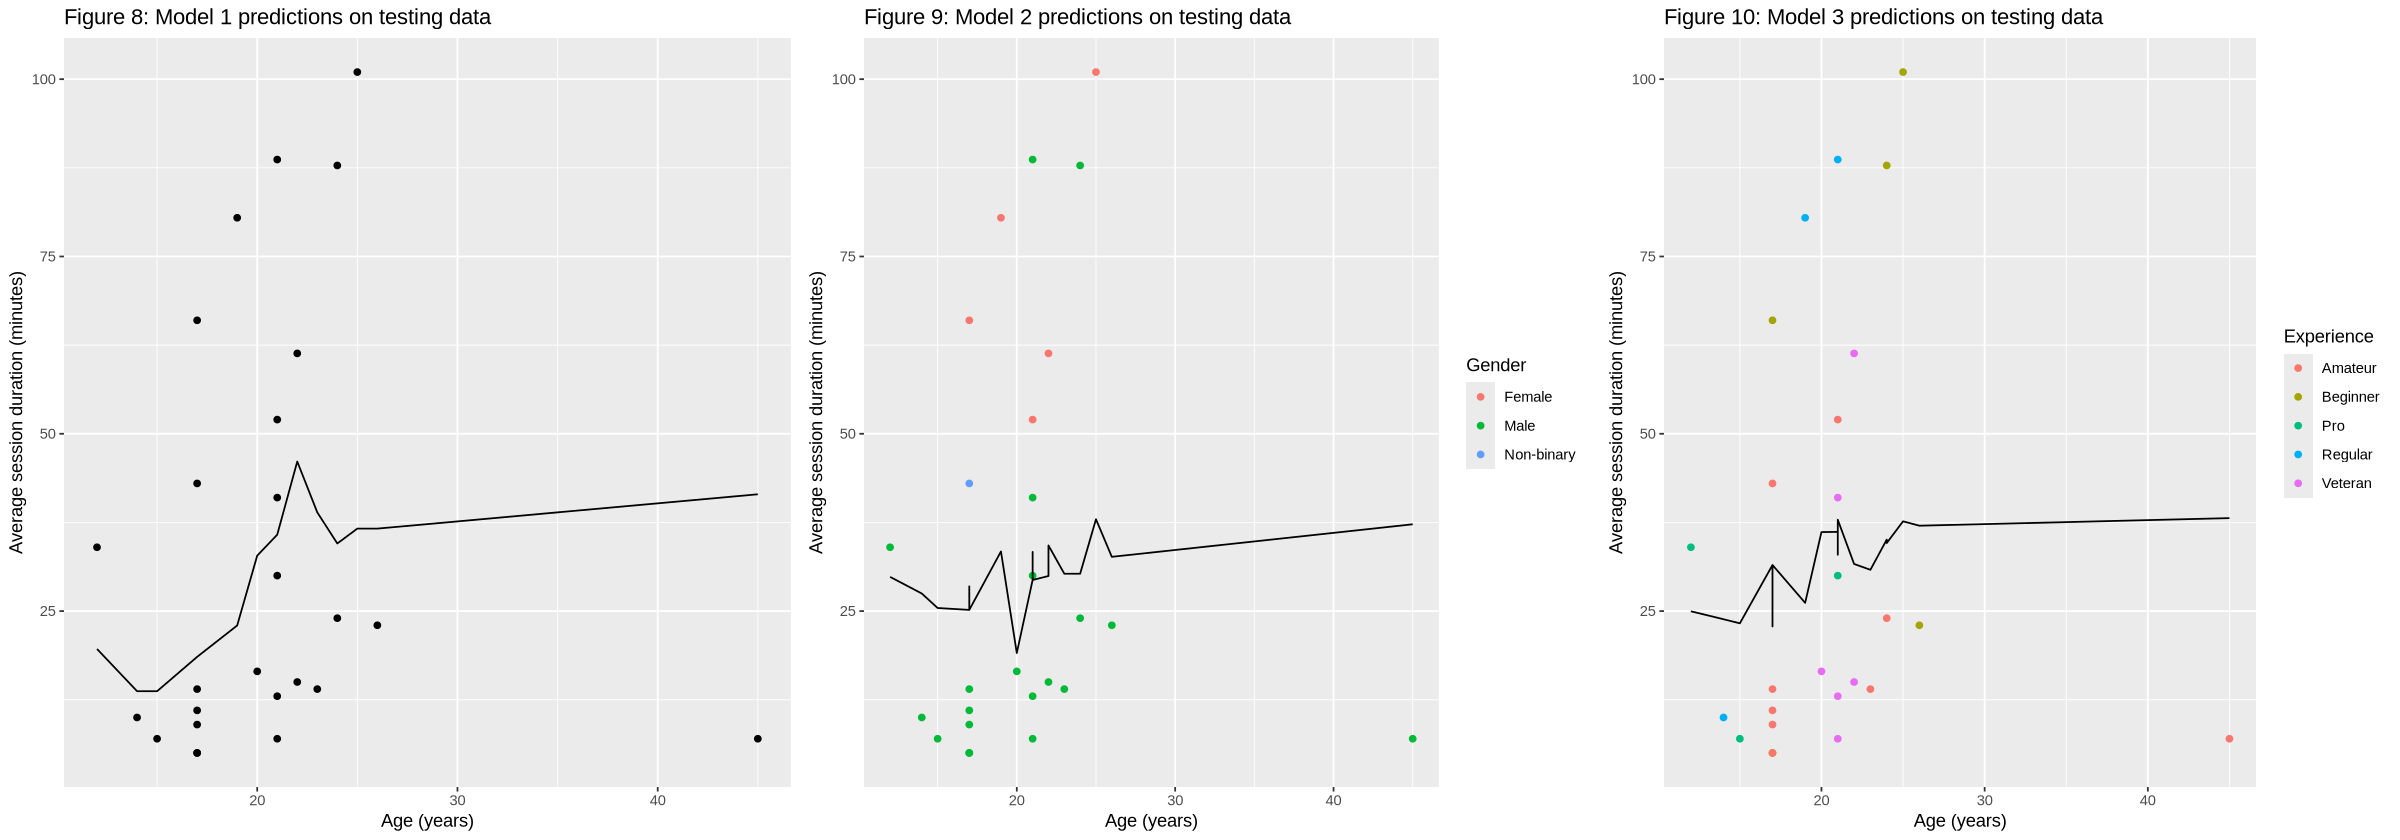

In [21]:
# Model predictions against testing data
options(repr.plot.width = 20)

model1_testing_comparison <- model1_best_fit |>
    predict(players_testing) |>
    bind_cols(players_testing) |>
    ggplot() +
    geom_point(aes(x = Age, y = avg_session_duration)) +
    geom_line(aes(x = Age, y = .pred)) +
    labs(title = "Figure 8: Model 1 predictions on testing data",
         x = "Age (years)",
         y = "Average session duration (minutes)")

model2_testing_comparison <- model2_best_fit |>
    predict(players_testing) |>
    bind_cols(players_testing) |>
    ggplot() +
    geom_point(aes(x = Age, y = avg_session_duration, color = gender)) +
    geom_line(aes(x = Age, y = .pred)) +
    labs(title = "Figure 9: Model 2 predictions on testing data",
         x = "Age (years)",
         y = "Average session duration (minutes)",
         color = "Gender")

model3_testing_comparison <- model3_best_fit |>
    predict(players_testing) |>
    bind_cols(players_testing) |>
    ggplot() +
    geom_point(aes(x = Age, y = avg_session_duration, color = experience)) +
    geom_line(aes(x = Age, y = .pred)) +
    labs(title = "Figure 10: Model 3 predictions on testing data",
         x = "Age (years)",
         y = "Average session duration (minutes)",
         color = "Experience")

plot_grid(model1_testing_comparison, model2_testing_comparison, model3_testing_comparison, ncol = 3)

**Purpose**: to evaluate the three models against the testing data

**Observations**: The first model has a very similar prediction line compared to the evaluation against training data. The other two models seem to be more "adaptive" to the different set of observations. The third model has a very brief but sharp downward spike for age 17, where there are four points lower than the prediction line. The second and third models have pretty narrow ranges of prediction compared to the first model.

## Discussion

Our goal in this research was to predict the average session length based on user type and age. However, the models utilized in this study&mdash;namely K-Nearest Neighbors (KNN) and linear regression&mdash;had limited success. The Root Mean Square Percentage Error values were all around 30 in every situation, meaning that our predictions were off by about 30 minutes on average. This level of error suggests that the models had trouble making accurate predictions based on the context provided by the data that was available.

One of the key reasons the performance has fallen short is the extreme variability built into the target variable. For all categories of user and all different ages, there were considerable variations in session duration. This widespread variability makes it difficult for techniques like KNN or linear regression to detect meaningful patterns. KNN works on the basis that nearby data points are going to return similar responses; it is easily deceived by data discontinuities in the local data neighborhoods. Likewise, linear regression relies on the hypothesis of a linear association between independent variables and response variable&mdash;a hypothesis that fails here because of the heterogeneity and scatter in session time values.

Another reason behind our results is the limited predictability of the variables we included in our analysis. Despite the significant contributions of category and age variables, these can be less strong as predictors of session length. More detailed behavioral or contextual variables&mdash;e.g., the hour of day, the type of activity, or the type of device used&mdash;are likely to lead to a better understanding of session length variation and an increased accuracy in predictions. Based on these findings, follow-up efforts can benefit hugely through the use of advanced modeling techniques such as decision trees, random forests, or gradient boosting machines. Such models are better suited to tackling the nonlinearities and complex relationships between variables. In addition to this, use of feature engineering or dimensionality reduction exploration can unveil underlying patterns in the data that are not revealed in simpler models.

Even with the below-par performance of our models, the analysis has helped to expose important weaknesses related to both the data set and to the model approach. This work highlights the fundamental importance of feature selection and model selection in predictive efforts and gives a clear basis on which future projects to improve performance in similar contexts can be built.

These findings carry important implications for how game developers and analysts approach user engagement. The limited predictive power of demographic features suggests that relying solely on age or user type may not be effective for building personalized experiences, running targeted marketing campaigns, or allocating server resources. This highlights the need to collect richer behavioral data&mdash;such as time-of-day patterns, device usage, or gameplay preferences&mdash;that could reveal deeper insights. Future research could explore how incorporating such features, alongside more flexible machine learning models, might uncover hidden trends and improve the accuracy of session duration predictions.